In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(most_recent)

('2017-08-23',)


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(most_recent[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
last_year = most_recent_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
select = [Measurement.date, Measurement.prcp]
precipitation_query = session.query(*select).filter(Measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation = pd.DataFrame(precipitation_query, columns=['date', 'prcp'])
precipitation = precipitation.set_index('date')

# Sort the dataframe by date
precipitation=precipitation.sort_values(by='date')
precipitation=precipitation.groupby('date').max()
precipitation 


,prcp
date,
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


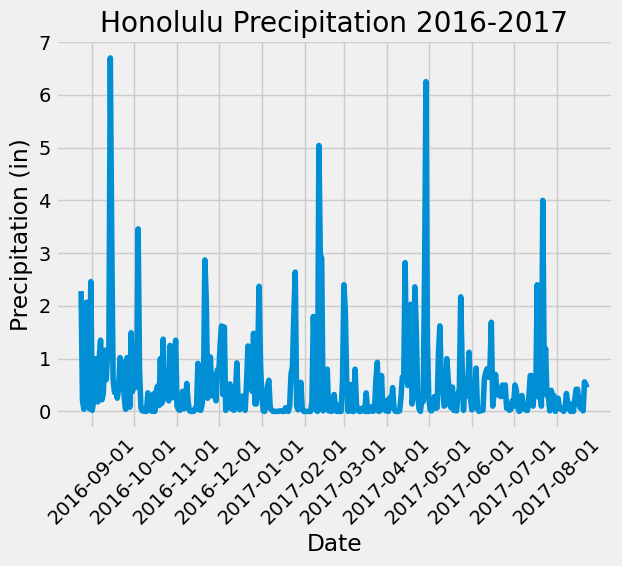

In [15]:

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(precipitation)
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Honolulu Precipitation 2016-2017")
ticks = ["2016-09-01", "2016-10-01", "2016-11-01", "2016-12-01", "2017-01-01", "2017-02-01", "2017-03-01", "2017-04-01", "2017-05-01", "2017-06-01", "2017-07-01", "2017-08-01"]
plt.xticks(ticks, rotation = 45)
plt.show
plt.savefig("output_data/Fig1.png")

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation.describe()

,prcp
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.id).count()
station_count

9

In [25]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()).all()

for station, count in station_activity:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Get the most active station ID from the previous query
most_active_station = station_activity[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
    .filter(Measurement.station == most_active_station).all()

# Extract the results
lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
avg_temp = temperature_stats[0][2]

# Print the temperature statistics
print(f"Temperature statistics for the most active station (Station ID: {most_active_station}):")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")


Temperature statistics for the most active station (Station ID: USC00519281):
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


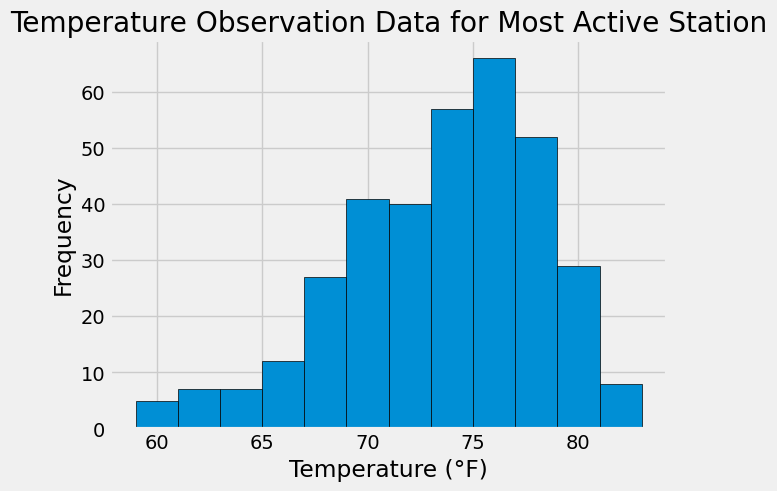

<Figure size 640x480 with 0 Axes>

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_data = session.query(Measurement.tobs) \
    .filter(Measurement.station == most_active_station) \
    .filter(Measurement.date >= last_year).all()

# Extract the temperature values
temperatures = [temp[0] for temp in temperature_data]

# Plot the histogram
plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for Most Active Station')
plt.show()
plt.savefig("output_data/Fig2.png")

# Close Session

In [28]:
# Close Session
session.close()